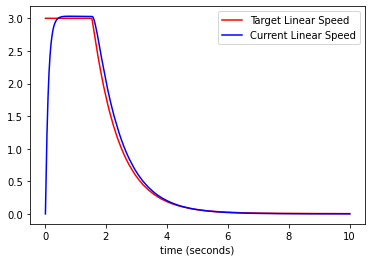

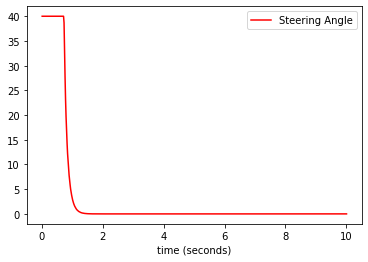

In [1]:
import sys
sys.path.append("../../")

#
# TO BE USED WITH godot/ackermann_no_physics
#

from lib.system.cart import *
from lib.dds.dds import *
from lib.utils.time import *
from lib.system.controllers import *
from lib.data.dataplot import *
from lib.system.polar import *

dds = DDS()
dds.start()

dds.subscribe(['tick'])

cart2d = AckermannSteering(10, # mass, 10kg 
                           0.8, # friction 
                           0.5, # 50cm radius motion wheel 
                           2.0) # 2m distance between motion and steering wheels

linear_speed_controller = PID_Controller(50.0, 10.0, 0)
polar_position = Polar2DController(1.0, 3.0, # kp = 2, vmax = 3 m/s
                                   5.0, math.radians(40)) # kp = 2, alpha_max = 40 deg

target_x = 5.0
target_y = 5.0

vdp = DataPlotter()
vdp.set_x("time (seconds)")
vdp.add_y("target_speed", "Target Linear Speed")
vdp.add_y("current_speed", "Current Linear Speed")

sdp = DataPlotter()
sdp.set_x("time (seconds)")
sdp.add_y("angle", "Steering Angle")


t = Time()
t.start()
while t.get() < 10:

    dds.wait('tick')
    delta_t = t.elapsed()
    
    pose = cart2d.get_pose()

    (target_speed, steering_angle) = polar_position.evaluate(delta_t, target_x, target_y, pose)

    (v, w) = cart2d.get_speed()
    torque = linear_speed_controller.evaluate(delta_t, target_speed - v)
    
    cart2d.evaluate(delta_t, torque, steering_angle)

    dds.publish('X', pose[0], DDS.DDS_TYPE_FLOAT)
    dds.publish('Y', pose[1], DDS.DDS_TYPE_FLOAT)
    dds.publish('Theta', pose[2], DDS.DDS_TYPE_FLOAT)

    vdp.append_x(t.get())
    vdp.append_y("current_speed", v)
    vdp.append_y("target_speed", target_speed)
    
    sdp.append_x(t.get())
    sdp.append_y("angle", math.degrees(steering_angle))

vdp.plot()
sdp.plot()
dds.stop()
